In [358]:
##This is a framework of patch-based hyperspectral classification
import os
import time
import random
import spectral
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from sklearn.preprocessing import minmax_scale
from scipy.io import loadmat
from tqdm.notebook import tqdm
%matplotlib inline

In [359]:
##hypeperameters and experimental settings
RANDOM_SEED=666
MODEL_NAME = 'CNN1D' ## 
DATASET = 'PU'    ## PU  IP  SA  
TRAIN_RATE = 0.1  ## ratio of training data
VAL_RATE = 0.05    ## ratio of valuating data
EPOCH = 120    ##number of epoch
VAL_EPOCH = 1  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 64
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components   0:use origin data
NORM = True  ## normalization or not
PATCH_SIZE = 1 ## patchsize of input 3D cube   1:only spectral sequence
SAVE_PATH = f"results\\{MODEL_NAME}\\{DATASET}"
CHECK_POINT = None  ## path of check point model
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [360]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [361]:
def loadData(name): ## customize data and return data label and class_name
    data_path = os.path.join(os.getcwd(),'dataset')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_gt.mat'))['indian_pines_gt']
        class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                       "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats","Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat", "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas\\Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas\\Salinas_gt.mat'))['salinas_gt']
        class_name = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth','Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green','Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU_gt.mat'))['paviaU_gt']
        class_name = ['Asphalt', 'Meadows', 'Gravel', 'Trees','Painted metal sheets', 'Bare Soil', 
                      'Bitumen','Self-Blocking Bricks', 'Shadows']
    return data, labels, class_name


In [362]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

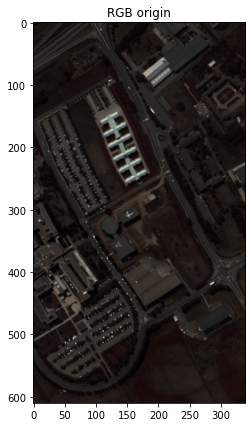

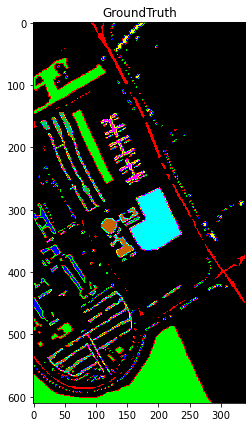

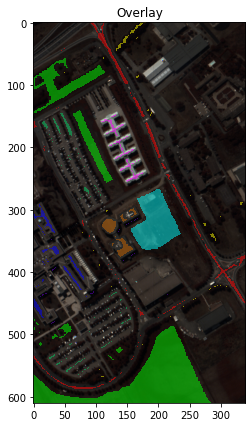

In [363]:
## display HSI
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [364]:
## show 3D cube
# %matplotlib auto
# spectral.view_cube(data,(30,20,10))   ## depends on wxpython and pyopengl

In [365]:
def applyPCA(X, numComponents=15, norm = True):
    """PCA and processing
    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional):  number of reserved components(Defaults to 15, 0 for no PCA).
        norm: normalization or not
    Returns:
        newX: processed data
        pca: 
    """
    if numComponents == 0:
        newX = X
    else:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents)   ##PCA and normalization
        newX = pca.fit_transform(newX)
    if norm:
        newX = minmax_scale(newX, axis=1)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, newX.shape[2]

In [366]:
data,N_PCA = applyPCA(data, N_PCA, NORM)
data.shape,N_PCA

((610, 340, 15), 15)

In [367]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [368]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

          class          train_num  val_num   test_num   total   
         Asphalt            663       332       5636      6631   
         Meadows            1865      932      15852     18649   
         Gravel             210       105       1784      2099   
          Trees             306       153       2605      3064   
  Painted metal sheets      134        67       1144      1345   
        Bare Soil           503       251       4275      5029   
         Bitumen            133        67       1130      1330   
  Self-Blocking Bricks      368       184       3130      3682   
         Shadows             95        47       805       947    
          total             4277      2138     36361     42776   


ImageView object:
  Interpolation       :  <default>

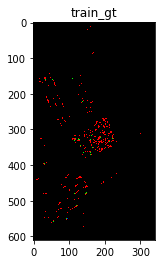

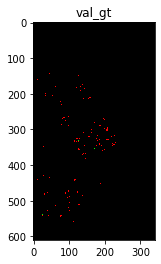

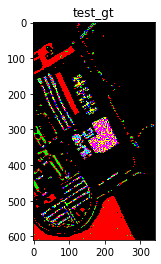

In [369]:
## display sampling info
sample_report = f"{'class': ^25}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{class_name[i-1]: ^25}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^25}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
spectral.imshow(classes=train_gt, title='train_gt')
spectral.imshow(classes=val_gt, title='val_gt')
spectral.imshow(classes=test_gt, title='test_gt')

In [370]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [371]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [372]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 1, 1]), tensor(2))

In [373]:
## establish model
## write you model here and use follow frame

# # class MODEL(nn.Module):

# #     def __init__(self, input_channels, n_classes, *args):
# #         super(MODEL, self).__init__()
        
# #     def forward(self, x):
# #         return x

## we use CNN1D as example
import math
from torch.nn import init
class MODEL(nn.Module):
    """
    Deep Convolutional Neural Networks for Hyperspectral Image Classification
    Wei Hu, Yangyu Huang, Li Wei, Fan Zhang and Hengchao Li
    Journal of Sensors, Volume 2015 (2015)
    https://www.hindawi.com/journals/js/2015/258619/
    """
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
            init.uniform_(m.weight, -0.05, 0.05)
            init.zeros_(m.bias)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.input_channels)
            x = self.pool(self.conv(x))
        return x.numel() 

    def __init__(self, input_channels, n_classes, kernel_size=None, pool_size=None):
        super(MODEL, self).__init__()
        if kernel_size is None:
           kernel_size = math.ceil(input_channels / 9)
        if pool_size is None:
           pool_size = math.ceil(kernel_size / 5)
        self.input_channels = input_channels

        self.conv = nn.Conv1d(1, 20, kernel_size)
        self.pool = nn.MaxPool1d(pool_size)
        self.features_size = self._get_final_flattened_size()
        self.fc1 = nn.Linear(self.features_size, 100)
        self.fc2 = nn.Linear(100, n_classes)
        self.apply(self.weight_init)

    def forward(self, x):
        x = x.squeeze(dim=-1).squeeze(dim=-1)
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = torch.tanh(self.pool(x))
        x = x.view(-1, self.features_size)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

##display network details
net = MODEL(N_PCA,n_classes=NUM_CLASS)
summary(net, input_size=(1,N_PCA,PATCH_SIZE,PATCH_SIZE),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

Layer (type (var_name))                  Param #    Kernel Shape Mult-Adds  Input Shape Output Shape
MODEL                                    --         --         --         --         --
├─Conv1d (conv)                          60         [1, 20, 2] 840        [1, 1, 15] [1, 20, 14]
├─MaxPool1d (pool)                       --         --         --         [1, 20, 14] [1, 20, 14]
├─Linear (fc1)                           28,100     [280, 100] 28,100     [1, 280]   [1, 100]
├─Linear (fc2)                           909        [100, 9]   909        [1, 100]   [1, 9]
Total params: 29,069
Trainable params: 29,069
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.12

In [374]:
## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
epoch_start = 0
model = MODEL(N_PCA,n_classes=NUM_CLASS) ##modify to you model 
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
if CHECK_POINT is not None:
    model_ckpt = torch.load(CHECK_POINT,map_location = device)
    model.load_state_dict(model_ckpt['state_dict'])
    epoch_start = model_ckpt['epoch']
    optimizer.load_state_dict(model_ckpt['optimizer'])
    loss_list = model_ckpt['loss_list']
    acc_list = model_ckpt['acc_list']
    val_acc_list = model_ckpt['val_acc_list']
    val_epoch_list = model_ckpt['val_epoch_list']

loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()
train_st = time.time()
run_error = False
try:
    for e in tqdm(range(epoch_start,EPOCH), desc="Training:"):
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            save_dict = {'state_dict':model.state_dict(), 'epoch':e+1, 'optimizer': optimizer.state_dict(),
                        'loss_list':loss_list, 'acc_list': acc_list, 'val_acc_list': val_acc_list, 'val_epoch_list':val_epoch_list}
            torch.save(save_dict,save_name)
except Exception as exc:
    print(exc)
    run_error = True
finally: 
    print(f'Stop in epoch {e}')
train_time = time.time()-train_st
print(f"training time: {train_time}")

Training::   0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

epoch 99/120 loss:0.0030673316041665683  acc:0.9263502454991817


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 99/120  val_acc:0.9162768942937325


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 100/120 loss:0.0030630362913211095  acc:0.9258826280102875


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 100/120  val_acc:0.9186155285313377


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 101/120 loss:0.0030254484275136005  acc:0.9279869067103109


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 101/120  val_acc:0.9158091674462114


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 102/120 loss:0.002996106050875467  acc:0.9277530979658639


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 102/120  val_acc:0.9144059869036483


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 103/120 loss:0.003002107605034987  acc:0.9291559504325462


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 103/120  val_acc:0.9181478016838166


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 104/120 loss:0.0029814238404179665  acc:0.9270516717325228


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 104/120  val_acc:0.9162768942937325


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 105/120 loss:0.003024243320054698  acc:0.9277530979658639


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 105/120  val_acc:0.9172123479887746


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 106/120 loss:0.003001118229947303  acc:0.928220715454758


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 106/120  val_acc:0.921889616463985


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 107/120 loss:0.0029044882950728145  acc:0.9303249941547814


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 107/120  val_acc:0.9195509822263798


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 108/120 loss:0.0029323544873236943  acc:0.9312602291325696


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 108/120  val_acc:0.9204864359214219


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 109/120 loss:0.002861465372951727  acc:0.9314940378770166


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 109/120  val_acc:0.9209541627689429


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 110/120 loss:0.002853888318879821  acc:0.9307926116436754


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 110/120  val_acc:0.9200187090739008


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 111/120 loss:0.002854051611497075  acc:0.933364507832593


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 111/120  val_acc:0.9195509822263798


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 112/120 loss:0.002878466892359495  acc:0.9310264203881226


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 112/120  val_acc:0.9083255378858747


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 113/120 loss:0.0028361963220977157  acc:0.9328968903436988


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 113/120  val_acc:0.9195509822263798


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 114/120 loss:0.002839898563850029  acc:0.9303249941547814


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 114/120  val_acc:0.9242282507015903


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 115/120 loss:0.002821583076980534  acc:0.9321954641103577


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 115/120  val_acc:0.9134705332086062


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 116/120 loss:0.0028301861310481803  acc:0.9340659340659341


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 116/120  val_acc:0.9186155285313377


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 117/120 loss:0.0028116435042491216  acc:0.9312602291325696


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 117/120  val_acc:0.912067352666043


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 118/120 loss:0.0028207851872144247  acc:0.9338321253214871


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 118/120  val_acc:0.9232927970065482


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 119/120 loss:0.0028058146138544644  acc:0.9352349777881693


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 119/120  val_acc:0.921421889616464
Stop in epoch 119
training time: 6.990024566650391


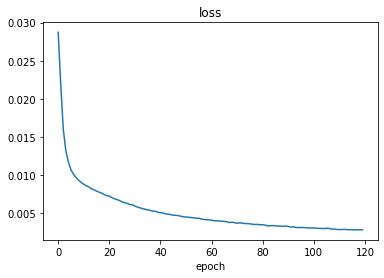

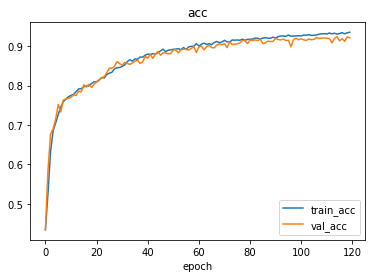

In [375]:
##display loss and acc
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
ax1.plot(np.arange(e+1),loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

In [376]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path, del_others = True):
    """get best model path by valuation list
    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir
    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    if del_others:
        for f in os.listdir(save_path):
            if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
                os.remove(os.path.join(save_path,f))
    return best_model_path

best model:epoch_114_acc_0.9242.pth


  0%|          | 0/3241 [00:00<?, ?it/s]

inferring time: 5.102280139923096


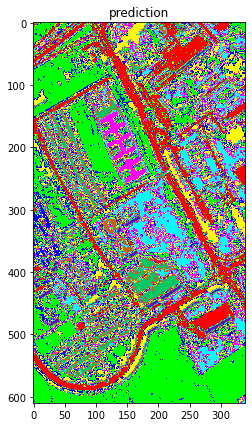

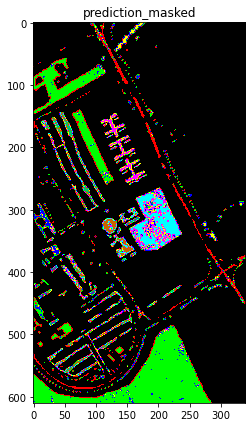

In [377]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH, not run_error)

best_model = MODEL(N_PCA,n_classes=NUM_CLASS)  ## modify to you model

best_model.load_state_dict(torch.load(best_model_path)['state_dict'])
## inference
best_model.to(device)
best_model.eval()
pred_map = []
infer_st = time.time() 
for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
infer_time = time.time() - infer_st
print(f"inferring time: {infer_time}")
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [378]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9181265641759028
AA: 0.8874928217421565
Kappa: 0.8908014237059838
training time: 6.990024566650391
inferring time: 5.102280139923096
                      precision    recall  f1-score   support

             Asphalt     0.9201    0.9312    0.9256      5636
             Meadows     0.9438    0.9715    0.9574     15852
              Gravel     0.8413    0.6570    0.7378      1784
               Trees     0.9425    0.8303    0.8829      2605
Painted metal sheets     0.9853    0.9965    0.9909      1144
           Bare Soil     0.9106    0.8816    0.8959      4275
             Bitumen     0.8282    0.8531    0.8405      1130
Self-Blocking Bricks     0.8063    0.8712    0.8375      3130
             Shadows     0.9889    0.9950    0.9920       805

            accuracy                         0.9181     36361
           macro avg     0.9074    0.8875    0.8956     36361
        weighted avg     0.9180    0.9181    0.9170     36361

